In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from mpl_toolkits.mplot3d import Axes3D

In [55]:
transaction = pd.read_csv('transaction_data.csv')

In [56]:
transaction['TOTAL_VALUE'] = transaction['QUANTITY'] * transaction['SALES_VALUE']
transaction.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,TOTAL_VALUE
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,0.99
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1.21
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.50


In [57]:
recency = transaction.groupby('household_key')['DAY'].unique().map(lambda x: np.sort(x)).\
map(lambda x: (365*2+1) if len(x) == 1 else x[-1] - x[-2])

rfm = pd.DataFrame({'Recency': recency.values}, index=recency.index)

frequency = transaction.groupby('household_key')['household_key'].count()
rfm['Frequency'] = frequency

monetary = transaction.groupby('household_key')['TOTAL_VALUE'].sum()
rfm['Monetary'] = monetary

rfm.head()

,Recency,Frequency,Monetary
household_key,,,
1,9,1727,5368.86
2,46,714,2362.64
3,28,922,144614.43
4,10,301,1747.05
5,10,222,859.05


## First Approach: RFM Segmentation

In [58]:
# create f_score and m_score
fscore = []
mscore = []

columns = ['Frequency', 'Monetary']
score_str = ['fscore', 'mscore']
score = [fscore, mscore]

for n in range(len(columns)):
    rfm = rfm.sort_values(columns[n], ascending=False)
    
    ordering = np.arange(rfm.shape[0])
    rfm['ordering'] = ordering
    
    for i, row in rfm.iterrows():
        if row['ordering'] <= np.ceil(2500/3):
            score[n].append(3)
        elif np.ceil(2500/3) < row['ordering'] <= np.ceil(2500/3*2):
            score[n].append(2)
        else:
            score[n].append(1)
    
    rfm[score_str[n]] = score[n]

In [59]:
# create r_score
rfm = rfm.drop('ordering', axis=1)

rscore = []

rfm = rfm.sort_values('Recency', ascending=True)

ordering = np.arange(rfm.shape[0])
rfm['ordering'] = ordering

for i, row in rfm.iterrows():    
    if row['ordering'] <= np.ceil(2500/3):
        rscore.append(3)
    elif np.ceil(2500/3) < row['ordering'] <= np.ceil(2500/3*2):
        rscore.append(2)
    else:
        rscore.append(1)

rfm.insert(loc=3, column='rscore', value=rscore)

In [60]:
rfm['RFM_Score'] = rfm['rscore'] + rfm['fscore'] + rfm['mscore']

score_labels = ['Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(x=rfm['RFM_Score'],q=3,labels=score_labels)
rfm['RFM_Level'] = score_groups.values

In [69]:
rfm.head(20)

,Recency,Frequency,Monetary,rscore,fscore,mscore,ordering,RFM_Score,RFM_Level
household_key,,,,,,,,,
1023,1,4403,1.941294e+08,3,3,3,0,9,Gold
145,1,475,2.343830e+03,3,2,1,1,6,Silver
986,1,654,2.319100e+03,3,2,1,2,6,Silver
1808,1,536,2.294730e+03,3,2,1,3,6,Silver
882,1,1578,3.261322e+06,3,3,3,4,9,Gold
836,1,543,2.277430e+03,3,2,1,5,6,Silver
282,1,1259,3.351160e+06,3,3,3,6,9,Gold
2019,1,3801,3.359049e+06,3,3,3,7,9,Gold
1791,1,1003,3.450374e+06,3,2,3,8,8,Gold


## Second Approach: K-Means Clustering

In [70]:
rfm.head()

,Recency,Frequency,Monetary,rscore,fscore,mscore,ordering,RFM_Score,RFM_Level
household_key,,,,,,,,,
1023,1,4403,1.941294e+08,3,3,3,0,9,Gold
145,1,475,2.343830e+03,3,2,1,1,6,Silver
986,1,654,2.319100e+03,3,2,1,2,6,Silver
1808,1,536,2.294730e+03,3,2,1,3,6,Silver
882,1,1578,3.261322e+06,3,3,3,4,9,Gold


In [73]:
# feature scaling
X = rfm[['Recency','Frequency','Monetary']]
X_sc = StandardScaler().fit_transform(X)
Xsc_df = pd.DataFrame(X_sc,columns=['Recency_sc','Frequency_sc','Monetary_sc'],
                     index=rfm.index)
Xsc_df.head()

C:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Recency_sc,Frequency_sc,Monetary_sc
household_key,,,
1023,-0.390349,3.368421,20.948175
145,-0.390349,-0.563915,-0.358511
986,-0.390349,-0.384717,-0.358513
1808,-0.390349,-0.502847,-0.358516
882,-0.390349,0.540303,-0.000817


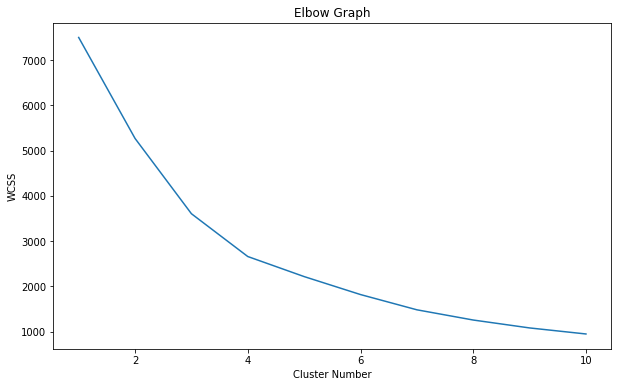

In [78]:
# k-means elbow method
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(Xsc_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1,11), wcss)
plt.title('Elbow Graph')
plt.xlabel('Cluster Number')
plt.ylabel('WCSS')
plt.show()

In [80]:
# k-means silhouette score
for i in range(2,11):
    model = KMeans(n_clusters=i,init='k-means++',random_state=0).fit(Xsc_df)
    preds = model.labels_
    sil_score = silhouette_score(Xsc_df.iloc[:,:3], preds, metric='euclidean')
    print('silhouette score: {} for cluster no: {}'.format(sil_score,i))

silhouette score: 0.5596382603531512 for cluster no: 2
silhouette score: 0.6029792027050299 for cluster no: 3
silhouette score: 0.5213795598720108 for cluster no: 4
silhouette score: 0.5036587895117591 for cluster no: 5
silhouette score: 0.5166232104951587 for cluster no: 6
silhouette score: 0.4546853676859668 for cluster no: 7
silhouette score: 0.4522120520464503 for cluster no: 8
silhouette score: 0.45298817337212494 for cluster no: 9
silhouette score: 0.41685605591529856 for cluster no: 10


### 3D scatter plot (with clusters) for Recency_sc, Frequency_sc & Monetary_sc
    - n_clusters = 3 (based on silhouette score computed in previous cell)

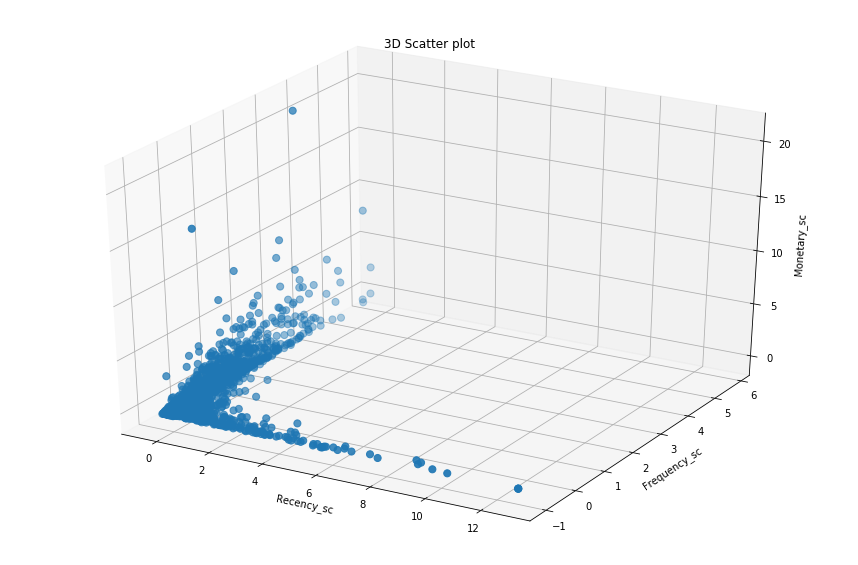

In [135]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xsc_df['Recency_sc'],Xsc_df['Frequency_sc'],Xsc_df['Monetary_sc'],s=50)
ax.set_title('3D Scatter plot')
ax.set_xlabel('Recency_sc')
ax.set_ylabel('Frequency_sc')
ax.set_zlabel('Monetary_sc')

plt.show()

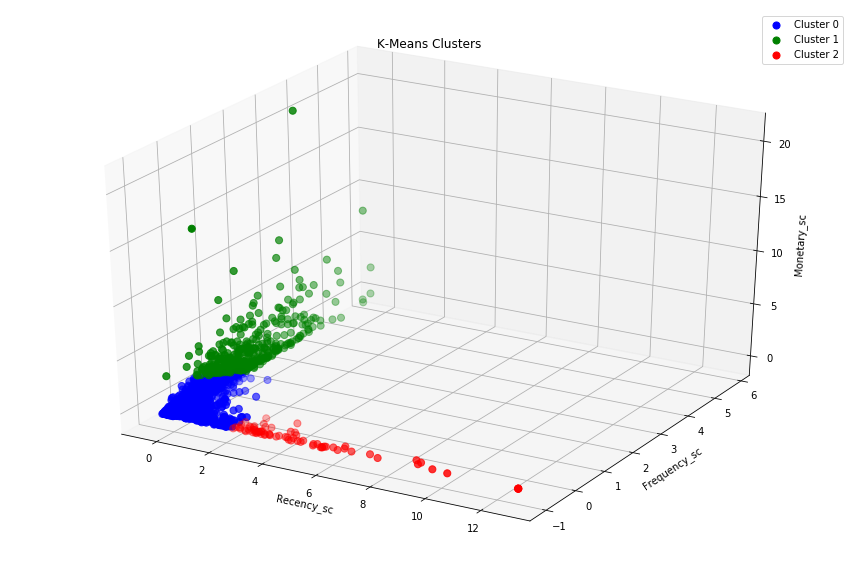

In [137]:
model = KMeans(n_clusters=3,init='k-means++',random_state=0).fit(Xsc_df)
preds = model.labels_
X3_df = Xsc_df
X3_df['Cluster'] = preds

fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111,projection='3d')
colors = ['blue', 'green', 'red']

for i in range(3):
    dx.scatter(X3_df[X3_df['Cluster'] == i]['Recency_sc'],
              X3_df[X3_df['Cluster'] == i]['Frequency_sc'],
              X3_df[X3_df['Cluster'] == i]['Monetary_sc'],
              c=colors[i],
              label='Cluster' + ' ' + str(i),
              s=50)
    
dx.set_title('K-Means Clusters')
dx.set_xlabel('Recency_sc')
dx.set_ylabel('Frequency_sc')
dx.set_zlabel('Monetary_sc')
dx.legend()

plt.show()

### Silhouette scores for K-Means modeled after various combinations of standardized features

In [81]:
# recency_sc, frequency_sc - silhouette score
for i in range(2,11):
    model = KMeans(n_clusters=i,init='k-means++',random_state=0).fit(Xsc_df[['Recency_sc','Frequency_sc']])
    preds = model.labels_
    sil_score = silhouette_score(Xsc_df[['Recency_sc','Frequency_sc']],
                                 preds, metric='euclidean')
    print('silhouette score: {} for cluster no: {}'.format(sil_score,i))

silhouette score: 0.756149238184157 for cluster no: 2
silhouette score: 0.5873545560602615 for cluster no: 3
silhouette score: 0.4964999404861772 for cluster no: 4
silhouette score: 0.5349647596150163 for cluster no: 5
silhouette score: 0.46985606953625136 for cluster no: 6
silhouette score: 0.49883522584524836 for cluster no: 7
silhouette score: 0.48638433439681905 for cluster no: 8
silhouette score: 0.4637549014338702 for cluster no: 9
silhouette score: 0.45461925112712304 for cluster no: 10


In [83]:
# recency_sc, monetary_sc - silhouette score
for i in range(2,11):
    model = KMeans(n_clusters=i,init='k-means++',random_state=0).fit(Xsc_df[['Recency_sc','Monetary_sc']])
    preds = model.labels_
    sil_score = silhouette_score(Xsc_df[['Recency_sc','Monetary_sc']],
                                 preds, metric='euclidean')
    print('silhouette score: {} for cluster no: {}'.format(sil_score,i))

silhouette score: 0.8187751138374769 for cluster no: 2
silhouette score: 0.8023217477370855 for cluster no: 3
silhouette score: 0.7530184063864555 for cluster no: 4
silhouette score: 0.7545207121203608 for cluster no: 5
silhouette score: 0.6736311321437352 for cluster no: 6
silhouette score: 0.675123437856052 for cluster no: 7
silhouette score: 0.6672962624561305 for cluster no: 8
silhouette score: 0.6292582481757083 for cluster no: 9
silhouette score: 0.6235239114560603 for cluster no: 10


In [85]:
# frequency_sc, monetary_sc - silhouette score
for i in range(2,11):
    model = KMeans(n_clusters=i,init='k-means++',random_state=0).fit(Xsc_df[['Frequency_sc','Monetary_sc']])
    preds = model.labels_
    sil_score = silhouette_score(Xsc_df[['Frequency_sc','Monetary_sc']],
                                 preds, metric='euclidean')
    print('silhouette score: {} for cluster no: {}'.format(sil_score,i))

silhouette score: 0.6593485444431665 for cluster no: 2
silhouette score: 0.5939979280531441 for cluster no: 3
silhouette score: 0.5826481184226979 for cluster no: 4
silhouette score: 0.5360800417935602 for cluster no: 5
silhouette score: 0.5390283043725611 for cluster no: 6
silhouette score: 0.5007317697797901 for cluster no: 7
silhouette score: 0.485241679147152 for cluster no: 8
silhouette score: 0.463938550837967 for cluster no: 9
silhouette score: 0.46441536254699806 for cluster no: 10


### Scatterplot for recency_sc and monetary_sc variables with n_clusters = 2
    - Silhouette scores across K-Means modeled after standardized variables in recency, frequency and monetary showed that two clusters for recency_sc and monetary_sc did best
    
    - Purple data points belong to Cluster 0: customers who have low recency value (their purchases were more recent) and high monetary value (higher spending)
    
    - Yellow data points belong to Cluster 1: customers who have high recency value (their purchases were less recent) and low monetary value (lower spending)

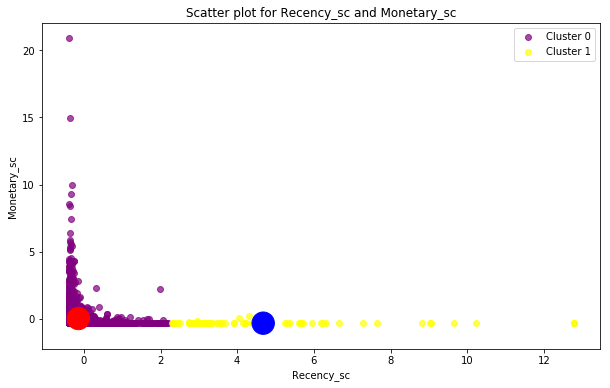

In [133]:
# scatter plot for recency_sc, monetary_sc
model = KMeans(n_clusters=2,init='k-means++',random_state=0).fit(Xsc_df[['Recency_sc','Monetary_sc']])
preds = model.labels_
centroids = pd.DataFrame(model.cluster_centers_,columns=['xc','yc'])
Xrm_df = Xsc_df[['Recency_sc','Monetary_sc']]
Xrm_df['Cluster'] = preds

colors = ['purple','yellow']

fig, ax = plt.subplots(figsize=(10,6))
for i in range(2):
    ax.scatter(Xrm_df[Xrm_df['Cluster'] == i]['Recency_sc'],
              Xrm_df[Xrm_df['Cluster'] == i]['Monetary_sc'],
              c=colors[i],
              alpha=0.7,
              label='Cluster' + ' ' + str(i))
    
#ax.scatter(Xsc_df['Recency_sc'],Xsc_df['Monetary_sc'],c=preds,alpha=0.7)
ax.scatter(centroids.iloc[:,0],centroids.iloc[:,1],c=['r','b'],s=500)
ax.set_title('Scatter plot for Recency_sc and Monetary_sc')
ax.set_xlabel('Recency_sc')
ax.set_ylabel('Monetary_sc')
ax.legend(['Cluster 0', 'Cluster 1'])
plt.show()

In [142]:
Xrm_df[Xrm_df['Cluster'] == 0].iloc[:10,:]

,Recency_sc,Monetary_sc,Cluster
household_key,,,
1023,-0.390349,20.948175,0
145,-0.390349,-0.358511,0
986,-0.390349,-0.358513,0
1808,-0.390349,-0.358516,0
882,-0.390349,-0.000817,0
836,-0.390349,-0.358518,0
282,-0.390349,0.009043,0
2019,-0.390349,0.009909,0
1791,-0.390349,0.019933,0


In [143]:
Xrm_df[Xrm_df['Cluster'] == 1].iloc[:10,:]

,Recency_sc,Monetary_sc,Cluster
household_key,,,
1478,2.298554,-0.358756,1
1254,2.316600,-0.358734,1
1973,2.334646,-0.358564,1
213,2.352693,-0.358639,1
967,2.406832,-0.358724,1
234,2.460971,-0.358728,1
1243,2.515110,-0.358734,1
529,2.731666,-0.358408,1
1554,2.731666,-0.246584,1


In [144]:
Xrm_df.shape

(2500, 3)

In [103]:
Xrm_df['Cluster'].value_counts()

0    2426
1      74
Name: Cluster, dtype: int64